In [10]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import block_reduce


In [11]:
def brownian_motion(nparticles, nframes, nposframe, DGen, dt):
    """
    Simulates Brownian motion for multiple particles.
    """
    num_steps = nframes * nposframe
    trajectories = np.zeros((nparticles, num_steps, 2))
    for p in range(nparticles):
        steps = np.sqrt(2 * DGen * dt / nposframe) * np.random.randn(num_steps, 2)
        trajectories[p] = np.cumsum(steps, axis=0)
    return trajectories

def compute_centroid_positions(trajectory, nframes, nposframe):
    """
    Computes the centroid positions for each frame in the trajectory.
    """
    centroids = np.zeros((nframes, 2))
    for k in range(nframes):
        start = k * nposframe
        end = (k + 1) * nposframe
        segment = trajectory[start:end, :]
        centroid = np.mean(segment, axis=0)
        centroids[k, :] = centroid
    return centroids

def mean_square_displacement(trajectory):
    """
    Computes the MSD for a single trajectory.
    """
    num_steps = trajectory.shape[0]
    msd = np.zeros(num_steps)
    for tao in range(1, num_steps):
        diffs = trajectory[tao:] - trajectory[:num_steps-tao]
        squared_diffs = np.sum(diffs**2, axis=1)
        msd[tao] = np.mean(squared_diffs)
    return msd

def mean_square_displacement_from_centroids(centroids):
    """
    Computes the MSD from centroid positions over frames.
    """
    nframes = centroids.shape[0]
    msd = np.zeros(nframes)
    for tao in range(1, nframes):
        diffs = centroids[tao:] - centroids[:nframes-tao]
        squared_diffs = np.sum(diffs**2, axis=1)
        msd[tao] = np.mean(squared_diffs)
    return msd

def estimateDfromMSD(msd, time_lags, max_time_lag=None, dimensionality=2):
    """
    Estimates the diffusion coefficient D from MSD and time lag data.
    """
    if max_time_lag is not None:
        valid_indices = time_lags <= max_time_lag
        msd = msd[valid_indices]
        time_lags = time_lags[valid_indices]
    # Exclude zero time lag
    valid_indices = time_lags > 0
    msd = msd[valid_indices]
    time_lags = time_lags[valid_indices]
    # Fit linear model to MSD vs. time lag
    slope, intercept = np.polyfit(time_lags, msd, 1)
    D_estimate = slope / (2 * dimensionality)
    return D_estimate

def gaussian_2d(x, y, sigma, size, amplitude):
    """
    Generates a 2D Gaussian centered at (x, y).
    """
    grid_x, grid_y = np.meshgrid(np.arange(size), np.arange(size))
    gaussian = amplitude * np.exp(-((grid_x - x)**2 + (grid_y - y)**2) / (2 * sigma**2))
    return gaussian

def add_noise_background(image, background, poisson_noise, gaussian_noise, normalizeValue=-1):
    """
    Adds background and noise to an image.
    """
    noisy_image = image + background
    if poisson_noise:
        noisy_image = np.random.poisson(noisy_image)
    # Ensure noisy_image is float before adding Gaussian noise
    noisy_image = noisy_image.astype(np.float64)
    if gaussian_noise > 0:
        noisy_image += np.random.normal(0, gaussian_noise, image.shape)
    if normalizeValue > 0:
        noisy_image = noisy_image / noisy_image.max() * normalizeValue
    return noisy_image



In [12]:
def generateImagesAndEstimateDFromTrajs(
    trajectories, nparticles, nframes, npixel, factor_hr, nposframe, D, dt,
    fwhm_psf, pixelsize, flux, background, poisson_noise, gaussian_noise, normalizeValue=-1):
    """
    Generates images and estimates both fine and coarse diffusion coefficients (D) for each particle.
    """
    image_array = np.zeros((nparticles, nframes, npixel, npixel))
    D_estimates = np.zeros(nparticles)
    D_estimates_coarse = np.zeros(nparticles)
    num_steps = nframes * nposframe
    time_range_fine = np.arange(num_steps) * dt / nposframe

    for p in range(nparticles):
        trajectory = trajectories[p]
        frame_hr = np.zeros((nframes, npixel * factor_hr, npixel * factor_hr))
        frame_noisy = np.zeros((nframes, npixel, npixel))

        for k in range(nframes):
            start = k * nposframe
            end = (k + 1) * nposframe
            trajectory_segment = trajectory[start:end, :]
            xtraj = trajectory_segment[:, 0]
            ytraj = trajectory_segment[:, 1]

            # Generate frames
            for pos in range(nposframe):
                x_pos = xtraj[pos] * factor_hr + npixel * factor_hr / 2
                y_pos = ytraj[pos] * factor_hr + npixel * factor_hr / 2
                frame_spot = gaussian_2d(
                    x_pos, y_pos, 2.35 * fwhm_psf / pixelsize / factor_hr,
                    npixel * factor_hr, flux / nposframe
                )
                frame_hr[k] += frame_spot

            # Downsample and add noise
            frame_lr = block_reduce(frame_hr[k], block_size=(factor_hr, factor_hr), func=np.mean)
            frame_noisy[k] = add_noise_background(
                frame_lr, background, poisson_noise, gaussian_noise, normalizeValue
            )

        # Store the noisy images
        image_array[p] = frame_noisy

        # Estimate D from the full trajectory
        msd_full = mean_square_displacement(trajectory)
        D_estimates[p] = estimateDfromMSD(msd_full, time_range_fine)

        # Estimate D from centroids (coarse)
        centroids = compute_centroid_positions(trajectory, nframes, nposframe)
        time_range_coarse = np.arange(nframes) * dt
        msd_centroids = mean_square_displacement_from_centroids(centroids)
        D_estimates_coarse[p] = estimateDfromMSD(msd_centroids, time_range_coarse)

    return image_array, D_estimates, D_estimates_coarse


In [13]:
def plot_MSDs(msd_fine, msd_coarse, time_range_fine, time_range_coarse, D_estimate_fine, D_estimate_coarse):
    max_time_lag = time_range_coarse[-1]
    # Limit fine MSD to the maximum time lag of coarse MSD
    valid_indices = time_range_fine <= max_time_lag
    msd_fine = msd_fine[valid_indices]
    time_range_fine = time_range_fine[valid_indices]

    plt.figure(figsize=(8, 6))
    plt.plot(time_range_fine, msd_fine, label=f'Fine MSD (D={D_estimate_fine:.4f})')
    plt.plot(time_range_coarse, msd_coarse, 'o-', label=f'Coarse MSD (D={D_estimate_coarse:.4f})')
    plt.xlabel('Time Lag (s)')
    plt.ylabel('MSD (units^2)')
    plt.title('Mean Square Displacement Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()


In [14]:
# Simulation parameters
# Hyperparameters for simulation
nparticles = 10  # Number of particles
nframes = 8    # Number of steps in the simulation
nposframe = 10    # Number of position per frame
dt = 0.01        # Integration time frame in second (time between two frames)
DGen = 10000       # Diffusion coefficient in nm^2 per s (=0.001 (um^2)/s)
num_steps = nframes*nposframe
# Hyperparameters for image generation
npixel = 64 # number of image pixels
pixelsize = 100 # in nm 
fwhm_psf = 200 # full width half maximum (emulates microscope)
factor_hr = 5 # image high resulution factor
flux = 100 # number of photons per s
poisson_noise = 100 
gaussian_noise = 10
background = 100 # base background value
normalizeValue = 1000 # value by which all samples will be normalized ! Needs to be fixed and the same for all images !
n_val_im = 50

# Generate trajectories
trajectories = brownian_motion(nparticles, nframes, nposframe, DGen, dt)


In [15]:
# Generate images and estimate D
images, D_estimates_fine, D_estimates_coarse = generateImagesAndEstimateDFromTrajs(
    trajectories, nparticles, nframes, npixel=64, factor_hr=2, nposframe=nposframe, D=DGen, dt=dt,
    fwhm_psf=300, pixelsize=100, flux=1000, background=10, poisson_noise=True, gaussian_noise=2)



In [16]:
# Print estimated D values
print("Estimated Diffusion Coefficients:")
print("Particle\tFine D\t\tCoarse D")
for p in range(nparticles):
    print(f"{p}\t\t{D_estimates_fine[p]:.4f}\t\t{D_estimates_coarse[p]:.4f}")


Estimated Diffusion Coefficients:
Particle	Fine D		Coarse D
0		20551.2157		18963.1942
1		1788.1435		1787.7053
2		41965.4825		47735.7888
3		-410.7898		-718.3012
4		11199.6134		11139.5478
5		3363.1029		2906.3585
6		27478.5248		33153.3549
7		2609.3740		2219.8966
8		7011.1079		6283.1418
9		1149.8636		1073.2006


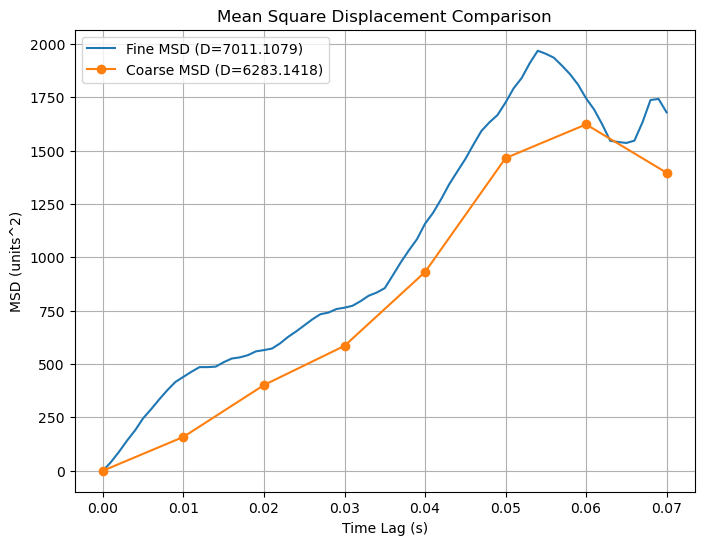

In [ ]:
# Select a particle to analyze
p = 8 

trajectory = trajectories[p]
msd_full = mean_square_displacement(trajectory)
time_range_full = np.arange(nframes * nposframe) * dt / nposframe
D_estimate_fine = D_estimates_fine[p]

# Compute centroids and MSD for coarse trajectory
centroids = compute_centroid_positions(trajectory, nframes, nposframe)
msd_centroids = mean_square_displacement_from_centroids(centroids)
time_range_centroids = np.arange(nframes) * dt
D_estimate_coarse = D_estimates_coarse[p]

# Plot the MSDs
plot_MSDs(msd_full, msd_centroids, time_range_full, time_range_centroids, D_estimate_fine, D_estimate_coarse)


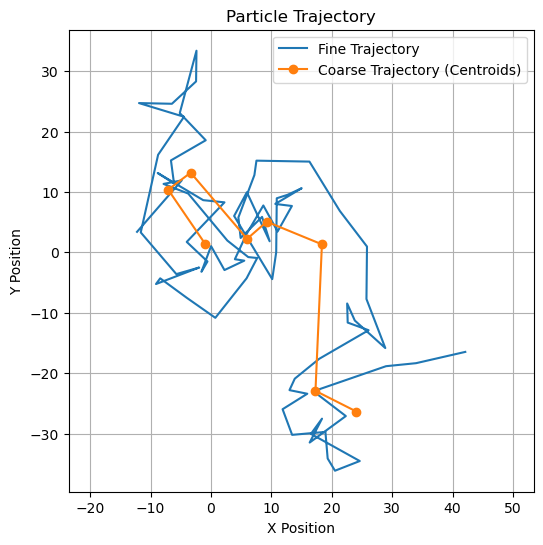

In [ ]:

plt.figure(figsize=(6, 6))
plt.plot(trajectory[:, 0], trajectory[:, 1], label='Fine Trajectory')
plt.plot(centroids[:, 0], centroids[:, 1], 'o-', label='Coarse Trajectory (Centroids)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Particle Trajectory')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


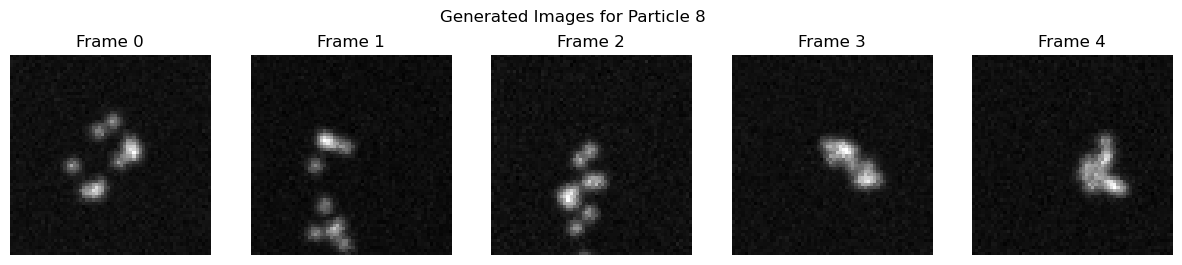

In [ ]:

num_images_to_show = min(nframes, 5)  
fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 3))
for i in range(num_images_to_show):
    axes[i].imshow(images[p, i], cmap='gray')
    axes[i].set_title(f'Frame {i}')
    axes[i].axis('off')
plt.suptitle('Generated Images for Particle {}'.format(p))
plt.show()
